## F560W - LMC Flat Region - skysub

Goal is to make a sky and subtract it from each of the cal images.  The sky is created by sigma clipping all the observations aligned in array coordinates to remove astronomical sources.  Performance is best in sparse fields.

Author: Karl Gordon

Last modified: 5 Jul 2022

### Variables controling processing and display

In [1]:
filter = "F560W"
basename = "jw0104000100"

# allow for varying background
scalebkg = False

# experimental options for additional exclusion
exclude_above = None  # exclude all regions above the provided value in MJy/sr
exclude_delta = None  # exclude all regions above bkg+exclude_delta given in MJy/sr
ds9region = None  # provide a ds9 region file of regions to exclude

# display range for images
drange_cal = [1., 6.]
drange_ssub = [-0.1, 5.0]
dmap = "afmhot"  # same as ds9 bb

# mosaicking options
crval = None
rotation = None
matchbkg = False
tweakreg = False
align_to_gaia = False

In [2]:
import os
import glob
import copy

from astropy.io import ascii, fits
from astropy.visualization import simple_norm

In [3]:
import astropy
print(astropy.__version__)

5.0.4


In [4]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds-pub.stsci.edu"

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [6]:
# List of possible data quality flags
from jwst.datamodels import dqflags
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

# custom helper routines
from helpers.jwst_helpers import show_image, overlay_catalog
from helpers.miri_clean import make_sky
from helpers.miri_helpers import miri_image3

In [7]:
import jwst
print(jwst.__version__)

1.5.4.dev17+geec8bb0d


## Make a sky and subtract it

In [8]:
miri_cal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_wcs_cal.fits")
simage = make_sky(miri_cal_files, scalebkg=scalebkg,
                  ds9regions=ds9region, exclude_above=exclude_above, exclude_delta=exclude_delta)

processing ./F560W/stage2/jw01040001001_03101_00001_mirimage_fixed_wcs_cal.fits
median sky = 1.5104665756225586
processing ./F560W/stage2/jw01040001001_03101_00002_mirimage_fixed_wcs_cal.fits
median sky = 1.5308306217193604
processing ./F560W/stage2/jw01040001001_03101_00003_mirimage_fixed_wcs_cal.fits
median sky = 1.5079231262207031
processing ./F560W/stage2/jw01040001001_03101_00004_mirimage_fixed_wcs_cal.fits
median sky = 1.507373332977295
processing ./F560W/stage2/jw01040001001_03101_00005_mirimage_fixed_wcs_cal.fits
median sky = 1.5144386291503906
processing ./F560W/stage2/jw01040001001_0310j_00001_mirimage_fixed_wcs_cal.fits
median sky = 2.009647846221924
processing ./F560W/stage2/jw01040001001_0310j_00002_mirimage_fixed_wcs_cal.fits
median sky = 1.7431590557098389
processing ./F560W/stage2/jw01040001001_0310j_00003_mirimage_fixed_wcs_cal.fits
median sky = 1.6190314292907715
processing ./F560W/stage2/jw01040001001_0310j_00004_mirimage_fixed_wcs_cal.fits
median sky = 1.60644769668

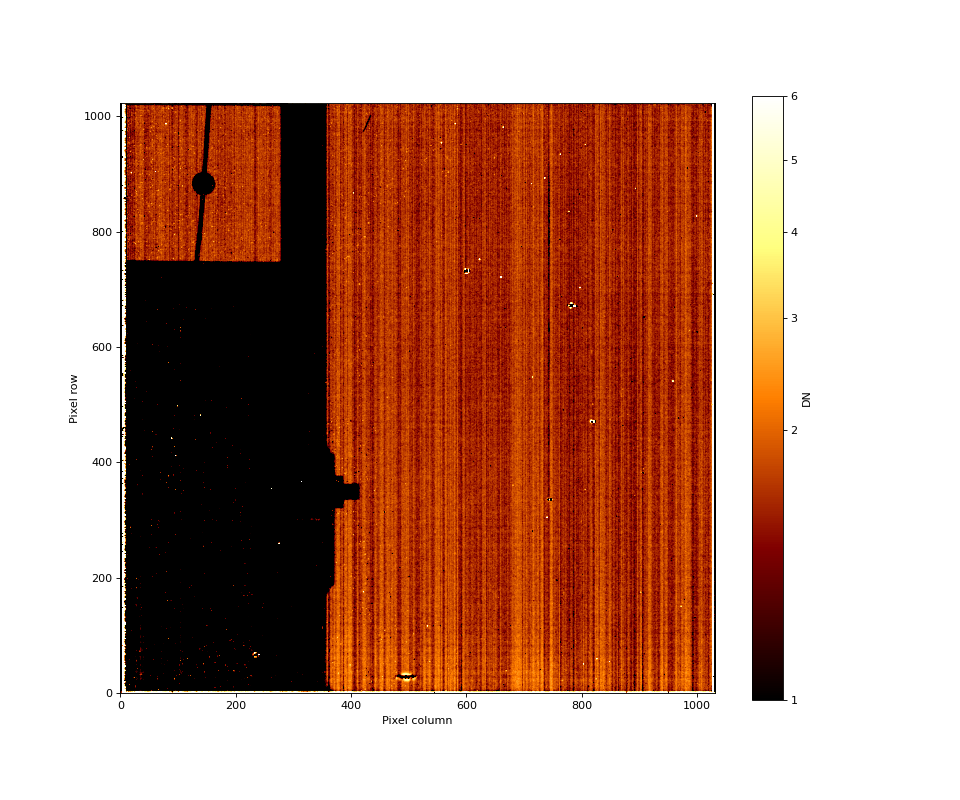

In [9]:
show_image(simage, drange_cal[0], drange_cal[1], dmap=dmap)
fits.writeto(f"./{filter}/stage3/{filter}_sky.fits", simage, overwrite=True)

### rerun CALWEBB_IMAGE3 with the new cleaned files

In [10]:
miri_cccal_files = glob.glob(f"./{filter}/stage2/*ge_fixed_wcs_skysub_cal.fits")
output_dir = f"./{filter}/stage3/"
print(miri_cccal_files)

miri_asn_name = f'miri_{filter}_stage3_asn_skysub'
miri_asn = asn_from_list.asn_from_list(miri_cccal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)

['./F560W/stage2/jw01040001001_03101_00001_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_03101_00002_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_03101_00003_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_03101_00004_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_03101_00005_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_0310j_00001_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_0310j_00002_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_0310j_00003_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_0310j_00004_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001001_0310j_00005_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001002_03101_00001_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001002_03101_00002_mirimage_fixed_wcs_skysub_cal.fits', './F560W/stage2/jw01040001002_03101_00003_mirimage_

In [11]:
miri_image3(miri_asn_file, output_dir, matchbkg=matchbkg,
            crval=crval, rotation=rotation, tweakreg=tweakreg, align_to_gaia=align_to_gaia)

2022-07-05 09:44:49,483 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-07-05 09:44:49,486 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-07-05 09:44:49,490 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-07-05 09:44:49,495 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-07-05 09:44:49,500 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-07-05 09:44:49,504 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-07-05 09:44:49,508 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2022-07-05 09:44:49,804 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('miri_F560W_stage3_asn_skysub.json',).
2022-07-05 09:44:49,827 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_

2022-07-05 09:45:21,852 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:23,914 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:26,037 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:28,062 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:30,079 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:32,141 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:34,081 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:36,134 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1839, 1563)
2022-07-05 09:45:38,166 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizz

2022-07-05 09:48:05,926 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:07,364 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:08,750 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:10,099 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:11,720 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:13,101 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:14,529 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:15,901 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1839, 1563)
2022-07-05 09:48:17,302 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (102

2022-07-05 09:48:51,688 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F560W/stage3/jw01040001001_0310j_00001_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-07-05 09:48:52,354 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F560W/stage3/jw01040001001_0310j_00002_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-07-05 09:48:53,307 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F560W/stage3/jw01040001001_0310j_00003_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-07-05 09:48:54,266 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F560W/stage3/jw01040001001_0310j_00004_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-07-05 09:48:54,926 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F560W/stage3/jw01040001001_0310j_00005_mirimage_fixed_wcs_skysub_a3001_crf.fits
2022-07-05 09:48:55,643 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./F560W/stage3/jw01040001002_03101_00001_mirimage_

2022-07-05 09:49:32,093 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:34,143 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:36,215 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:38,087 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:39,901 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:41,721 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:43,495 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:45,336 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:47,128 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:49:48,927 - stpipe.Image3Pipelin

2022-07-05 09:51:54,564 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:51:56,603 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:51:58,503 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:00,315 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:02,306 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:04,143 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:06,039 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:07,981 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:09,774 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:52:11,624 - stpipe.Image3Pipelin

2022-07-05 09:54:21,134 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:23,102 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:24,959 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:26,883 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:28,876 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:30,738 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:32,591 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:34,410 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:36,366 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1855, 1576)
2022-07-05 09:54:38,257 - stpipe.Image3Pipelin

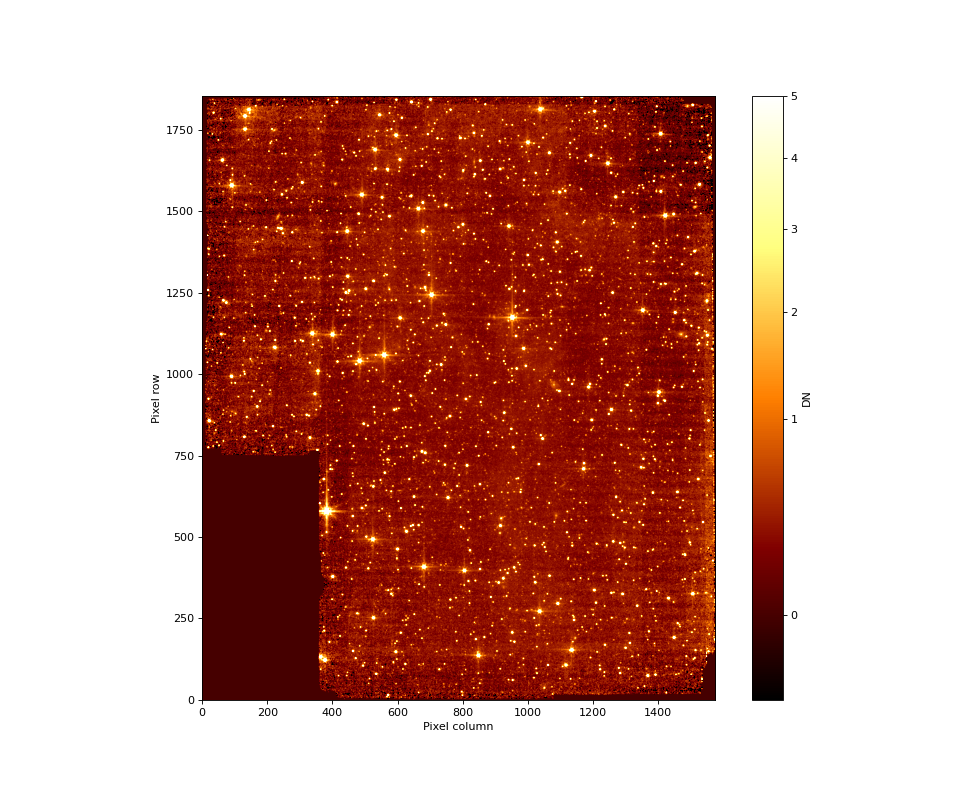

In [12]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_mosaic = datamodels.open(miri_mosaic_file)
drange = drange_cal
# Look at the mosaic
show_image(miri_mosaic.data, vmin=drange_ssub[0], vmax=drange_ssub[1], dmap=dmap)

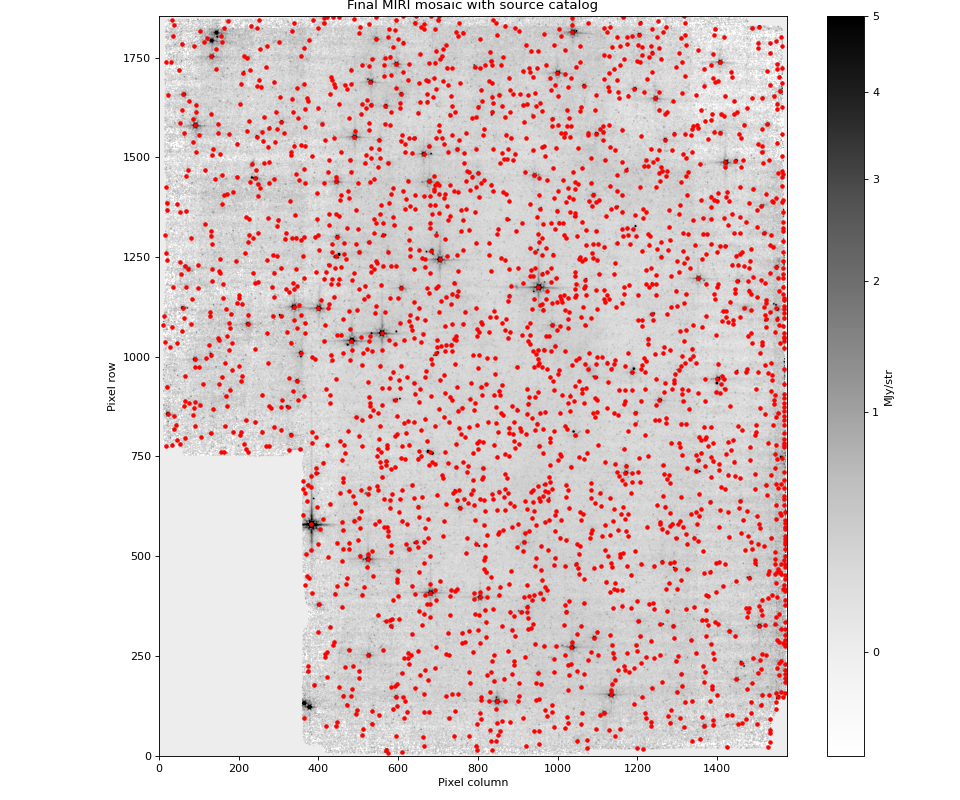

In [13]:
miri_catalog_file = output_dir + miri_asn_name + '_cat.ecsv'
# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)
# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=drange_ssub[0], vmax=drange_ssub[1],
                title='Final MIRI mosaic with source catalog', dmap="Greys")